In [16]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import random
import math
import timeit
import itertools
import warnings
import pickle
import gc
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from os.path import join, isfile
from collections import Counter
from fcmeans import FCM
import scipy.stats as stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans, SpectralClustering
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from PIL import Image
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, formatter={'float': lambda x: "{0:0.2f}".format(x)})


# #### STEP 1.2: Function Definitions

# Beacon operations
def queryBeacon(beacon_people):
    return (ternary[:, beacon_people] == 1).any(axis=1)

def getMutationAt(index):
    temp = maf.iloc[index]
    if temp["minor_freq"] == temp["maf"]:
        return temp["minor"] + temp["minor"] 
    else:
        return temp["major"] + temp["major"] 

def div(n, d):
    return n / d if d else 0

def rpaCalculate(tp,fp,tn,fn):
    recall = div(tp,(tp+fn)) 
    precision = div(tp,(tp+fp))
    accuracy = div((tp+tn),(tp+fp+tn+fn))
    return recall, precision, accuracy

# Performance method
def performance(person, reconstruction, eval_pos, reference):
    ind = np.logical_and(person[eval_pos] != np.squeeze(reference)[eval_pos], person[eval_pos] != "NN")
    tp = np.sum(reconstruction[eval_pos][ind] != np.squeeze(reference)[eval_pos][ind])
    fn = np.sum(ind) - tp
    fp = np.sum(reconstruction[eval_pos][~ind] != np.squeeze(reference)[eval_pos][~ind])
    tn = np.sum(~ind) - fp
    return tp, fp, tn, fn

def performance_f(test_people, reconstructed, add_count, cluster_count, eval_pos):
    total_values = np.zeros((4))
    best_matches = []
    # For all people in victim set
    for i in range(add_count):
        all_combinations = np.zeros((4, cluster_count))
        rpa = np.zeros((3, cluster_count))
        # For each cluster obtained
        for j in range(cluster_count):
            all_combinations[:, j] = performance(test_people[i], reconstructed[j], eval_pos, reference)
            rpa[:, j] = rpaCalculate(*all_combinations[:, j])
        ind = np.argmax(rpa[0,:]*rpa[1,:])       #Best-match index
        best_matches.append(ind)
        total_values += all_combinations[:, ind] #Add total tp-fp-tn-fn
    recall, precision, accuracy = rpaCalculate(*total_values)
    print("Recall_Micro_Avg    =", round(recall, 2),"\nPrecision_Micro_Avg =", round(precision, 2))
    return (precision,recall,accuracy), total_values, best_matches


# #### STEP 2: Choose random people and send query to Beacon to obtain No-Yes answers

def getNoYes( added_people, beacon_people): 
    # Query Beacon initially
    before = queryBeacon(beacon_people)
    # Add people
    updated_beacon = np.concatenate([added_people,beacon_people])
    # Query Beacon again
    after = queryBeacon(updated_beacon)
    # Find No-Yes SNPs' indices
    no_yes_indices = np.where(np.logical_and(before==False, after==True))[0]
    yes_yes_indices = np.where(np.logical_and(before==True, after==True))[0]
    print("Number of No-Yes SNP's : ", len(no_yes_indices))
    
    return no_yes_indices, added_people


# #### STEP 3: Correlation Model

def builtSNPNetwork(no_yes_indices, model_ind, reference):
    model = ternary[no_yes_indices][:, model_ind].astype(float)
    model[model==-1] = np.nan
    x = pairwise_distances(model, metric = "sokalmichener", n_jobs=-1)
    x = 1-np.nan_to_num(x)
    return x


def baseline_method(no_yes_indices, add_count, cluster_count=None):
    c = maf.iloc[no_yes_indices]

    # Calculate probabilities of SNP possibilities
    greater = c.loc[c['major_freq'] >= c['minor_freq']]
    smaller = c.loc[c['major_freq'] < c['minor_freq']]

    greater["maj-maj"] = greater['major'] + "" + greater['major']
    greater["mean"] = pd.concat([greater['major'] + "" + greater['minor'], greater['minor'] + "" + greater['major']], axis=1).min(axis=1)
    greater["min-min"] = greater['minor'] + "" + greater['minor']
    greater["p1"] = greater['major_freq']**2
    greater["p2"] = 2*greater['major_freq']*greater['minor_freq']
    greater["p3"] = greater['minor_freq']**2

    smaller["maj-maj"] = smaller['minor'] + "" + smaller['minor']
    smaller["mean"] = pd.concat([smaller['major'] + "" + smaller['minor'], smaller['minor'] + "" + smaller['major']], axis=1).min(axis=1)
    smaller["min-min"] = smaller['major'] + "" + smaller['major']
    smaller["p1"] = smaller['minor_freq']**2
    smaller["p2"] = 2*smaller['major_freq']*smaller['minor_freq']
    smaller["p3"] = smaller['major_freq']**2

    tt = pd.concat([greater,smaller], axis=0)
    tt.sort_index(inplace=True)

    genome_possibilities = tt[["maj-maj", "mean", "min-min"]].values
    probabilities = tt[["p1","p2","p3"]].values

    mutations = tt[["mean", "min-min"]].values
    mutation_probs = tt[["p2","p3"]].values

    # Randomly reconstruct the people's genome
    bins = []
    cumulative = probabilities.cumsum(axis=1)
    for i in range(add_count):
        uniform = np.random.rand(len(cumulative), 1)
        choices = (uniform < cumulative).argmax(axis=1)
        reconstructed = np.choose(choices, genome_possibilities.T)
        bins.append(reconstructed)
    bins = np.array(bins)
    
    # Be sure that at least one person has the mutation
    equality = np.sum((bins == reference[no_yes_indices].T), axis=0)
    changed_indices = np.where(equality==add_count)[0]

    index_choices = np.random.randint(add_count, size=len(equality))[changed_indices]

    non_zeros = mutation_probs[np.sum(mutation_probs, axis=1) != 0]
    probs = (non_zeros.T / np.sum(non_zeros, axis=1).T).T

    zeros = np.zeros((mutation_probs.shape[0], 2))
    zeros[np.sum(mutation_probs, axis=1) != 0] = probs
    probs = zeros[changed_indices]

    cum = probs.cumsum(axis=1)
    uni = np.random.rand(len(cum), 1)
    choi = (uni < cum).argmax(axis=1)
    res = np.choose(choi, mutations[changed_indices].T)

    bins.T[changed_indices, index_choices] = res
    # Reconstruct
    reconstructed = np.array([reference.T[0] for i in range(add_count)])
    reconstructed.T[no_yes_indices] = bins.T
    return reconstructed


# #### Spectral Clustering

def spectralClustering(no_yes_indices, add_count, x, reference, cluster_count=None):
    if not cluster_count:
        cluster_count = add_count
    sc = SpectralClustering(cluster_count, affinity='precomputed', n_init=100, n_jobs=-1)
    sc.fit(np.array(x))
    bins = []
    for i in range(cluster_count):
        temp = []
        for element in np.where(sc.labels_==i)[0]:
            temp.append(no_yes_indices[element])
        #print("Bin " + str(i) + " has " + str(len(temp)) + " SNP's")
        bins.append(temp)
    reconstructed = np.array([reference.T[0] for i in range(cluster_count)])
    for i in range(cluster_count):
        for j in bins[i]:
            reconstructed[i][j] = getMutationAt(j)
    return reconstructed

# #### Fuzzy Clustering

def fuzzyClustering(no_yes_indices, add_count, x, reference, cluster_count=None):
    if not cluster_count:
        cluster_count = add_count
    fcm = FCM(n_clusters=cluster_count)
    fcm.fit(x)
    soft_clusters = fcm.u
    bins = [[] for i in range(cluster_count)]
    for i in range(len(soft_clusters)):
        maxPos = np.argmax(soft_clusters[i])
        if soft_clusters[i][maxPos] <= 0.5:
            for j in np.where(soft_clusters[i] > (soft_clusters[i][maxPos] * 2 / 3))[0]:
                bins[j].append(no_yes_indices[i])
        else:
            bins[maxPos].append(no_yes_indices[i])
    reconstructed = np.array([reference.T[0] for i in range(cluster_count)])
    for i in range(cluster_count):
        for j in bins[i]:
            reconstructed[i][j] = getMutationAt(j)
    return reconstructed

In [22]:
def reconstruct(added_people, beacon_people):
    no_yes_ind, added_people   = getNoYes(added_people, beacon_people)
    model_ind                  = np.setdiff1d(phenoAllPeople, added_people)
    correlations               = builtSNPNetwork(no_yes_ind, model_ind, reference)
    
    add_count = added_people.shape[0]
    cluster_count = add_count
    beacon_size = beacon_people.shape[0]
    
    results = np.zeros((3, 3))

    print("\nSpectral Clustering")
    # Spectral
    reconstructed_spectral      = spectralClustering(no_yes_ind, add_count, correlations, reference)
    results[0, :],_,_           = performance_f(beacon.iloc[:, added_people].values.T, reconstructed_spectral,add_count,cluster_count,no_yes_ind) 
    
    print("\nBaseline Algorithm")
    # Baseline
    reconstructed_baseline      = baseline_method(no_yes_ind, add_count)
    results[1, :],_,_           = performance_f(beacon.iloc[:, added_people].values.T, reconstructed_baseline,add_count,cluster_count,no_yes_ind)  
    
    print("\nFuzzy Clustering")
    # Fuzzy
    reconstructed_fuzzy         = fuzzyClustering(no_yes_ind,add_count,correlations,reference)
    results[2, :],_,_           = performance_f(beacon.iloc[:, added_people].values.T, reconstructed_fuzzy,add_count,cluster_count,no_yes_ind)  
    return results

In [23]:
def plot(results):
    fig = plt.figure(dpi=100)
    viridis = cm.get_cmap('cividis', 5)
    ind = np.arange(3) 
    width = 0.17
    plt.bar(ind, results[1], width, label='Baseline Algorithm', color=viridis.colors[3], zorder=3)
    plt.bar(ind + width, results[0], width, label='Spectral Clustering', color=viridis.colors[2], zorder=3)
    plt.bar(ind + width*2, results[2], width, label='Fuzzy Clustering', color=viridis.colors[0], zorder=3)
    plt.ylabel('Scores')
    plt.title('Reconstruction Performance')
    plt.xticks(ind + width / 2, ('Precision', 'Recall', 'Accuracy'))
    plt.yticks(np.arange(0, 1.01, 0.1))
    plt.gca().yaxis.grid(linestyle=':', zorder=0)
    plt.legend(loc='center', bbox_to_anchor=(0.5, -0.15), ncol=3, fancybox=True, shadow=True)
    fig.subplots_adjust(bottom=0.2)
    canvas = FigureCanvas(fig)
    canvas.draw()
    s, (width, height) = canvas.print_to_buffer()
    image = np.fromstring(s, np.uint8).reshape((height, width, 4))
    return image

In [24]:
def reconstruction_risk(beacon_path, victim_path):
    test_beacon = pd.read_csv(beacon_path, index_col=0, delim_whitespace=True)
    test_victims = pd.read_csv(victim_path, index_col=0, delim_whitespace=True)
    beacon_people = test_beacon.columns.values
    beacon_people = np.where(np.in1d(beacon.columns, beacon_people))[0]
    added_people = test_victims.columns.values
    added_people = np.where(np.in1d(beacon.columns, added_people))[0]
    results = reconstruct(added_people, beacon_people)
    image = plot(results)
    return image

In [12]:
# Needed Files !
mainPath = ""

with open(join(mainPath, "MAF.pickle"), 'rb') as f:
    maf = pickle.load(f)

with open(join(mainPath, "Reference.pickle"), 'rb') as f:
    reference = pickle.load(f).values

with open(join(mainPath, "Beacon.pickle"), 'rb') as f:
    beacon = pickle.load(f)
    
with open(join(mainPath, "TernaryBeacon.pickle"), 'rb') as f:
    ternary = pickle.load(f)

phenoAllPeople = np.arange(beacon.shape[1])

Number of No-Yes SNP's :  10689

Spectral Clustering
Recall_Micro_Avg    = 0.91 
Precision_Micro_Avg = 0.81

Baseline Algorithm
Recall_Micro_Avg    = 0.23 
Precision_Micro_Avg = 0.21

Fuzzy Clustering
Recall_Micro_Avg    = 0.79 
Precision_Micro_Avg = 0.79


NameError: name 'image' is not defined

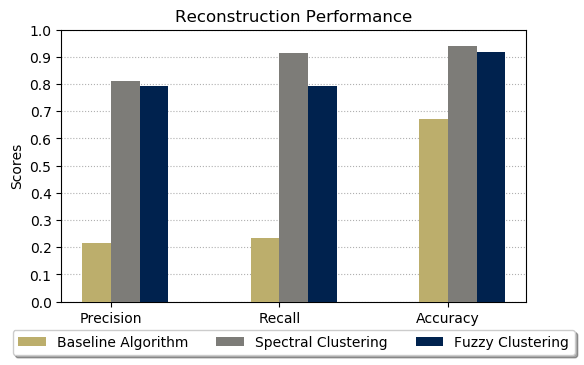

In [25]:
beacon_path = join(mainPath, "Test_Beacon.txt")
victim_path = join(mainPath, "Test_Victims.txt")
image_array = reconstruction_risk(beacon_path, victim_path)
img = Image.fromarray(image_array, 'RGBA')